### Import libraries, read Cryptocurrency data from CoinGecko API, and convert to usable DataFrame (merged_df)

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures

url_pre = 'https://api.coingecko.com/api/v3/coins/'
url_suf = '/market_chart?vs_currency=usd&days=150'
coins = ['dogecoin', 'bitcoin', 'ethereum']
list_of_dfs = []
for coin in coins:
    url = url_pre + coin + url_suf
    result = requests.get(url)
    j = result.json()
    prices = j['prices']
    prices_df = pd.DataFrame(prices, columns=['TimeStamp', '{} Price'.format(coin)])
    prices_df['TimeStamp'] = pd.to_datetime(prices_df['TimeStamp'], unit='ms').dt.round('1min')
    list_of_dfs.append(prices_df)
    

merged_df = pd.merge(list_of_dfs[0], list_of_dfs[1], how='left', on='TimeStamp')

for i in range(2, len(list_of_dfs)):
    merged_df = merged_df.merge(list_of_dfs[i], how='left', on='TimeStamp')
    
merged_df.tail()

,TimeStamp,dogecoin Price,bitcoin Price,ethereum Price
145,2021-06-06 00:00:00,0.372906,35546.985965,2624.768915
146,2021-06-07 00:00:00,0.372499,35834.474474,2711.547939
147,2021-06-08 00:00:00,0.333077,33451.383407,2580.535580
148,2021-06-09 00:00:00,0.327442,33557.150683,2528.022301
149,2021-06-10 00:57:00,0.339517,37155.648321,NaN


### 2. Extract features

In [2]:
def apply_changes(dataframe):
    a = dataframe.copy()
    a.dropna(inplace=True)
    #scale data
    #except for dogecoin Price, since this is eventually going to be the prediction/output #'dogecoin Price',
    features_to_scale = [
                        'bitcoin Price',
                        'ethereum Price'
                        ]
    
    a.dropna(inplace=True)
    for feature in features_to_scale:
        m = MinMaxScaler()
        X = a[feature].values.reshape(-1, 1)
        m.fit(X)
        MinMaxScaler(copy=True, feature_range=(0,1))
        a[feature] = m.transform(X)
        #the above line actually permanently replaces the column with its scaled version
     
    #phase-shift all features, this time including the bitcoin Price data
    features_to_shift = [
                        'dogecoin Price',
                        'bitcoin Price',
                        'ethereum Price',
                        ]
    
    for feature in features_to_shift:
        a['{} - 1d'.format(feature)] = a['{}'.format(feature)].shift(1)
        a['{} - 2d'.format(feature)] = a['{}'.format(feature)].shift(2)
    
    a.dropna(inplace=True)
    #just to be safe
        
    return a
    
training_data = apply_changes(merged_df)
pd.options.display.max_columns = None
training_data.head()

,TimeStamp,dogecoin Price,bitcoin Price,ethereum Price,dogecoin Price - 1d,dogecoin Price - 2d,bitcoin Price - 1d,bitcoin Price - 2d,ethereum Price - 1d,ethereum Price - 2d
2,2021-01-14,0.008650,0.211598,0.027605,0.008067,0.008856,0.105424,0.157688,0.000000,0.015142
3,2021-01-15,0.009467,0.265225,0.054666,0.008650,0.008067,0.211598,0.105424,0.027605,0.000000
4,2021-01-16,0.009326,0.191421,0.040305,0.009467,0.008650,0.265225,0.211598,0.054666,0.027605
5,2021-01-17,0.009265,0.175339,0.060313,0.009326,0.009467,0.191421,0.265225,0.040305,0.054666
6,2021-01-18,0.009028,0.161743,0.058639,0.009265,0.009326,0.175339,0.191421,0.060313,0.040305


### 3. Visualize Data
- Comment / uncomment to toggle features to plot.

Text(0, 0.5, 'Price(USD)')

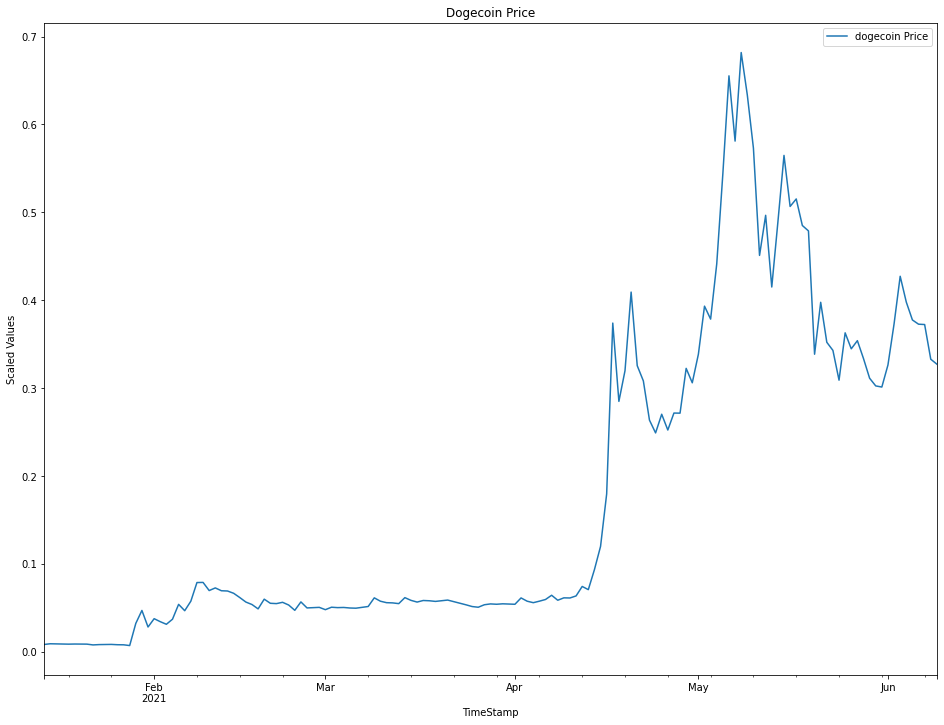

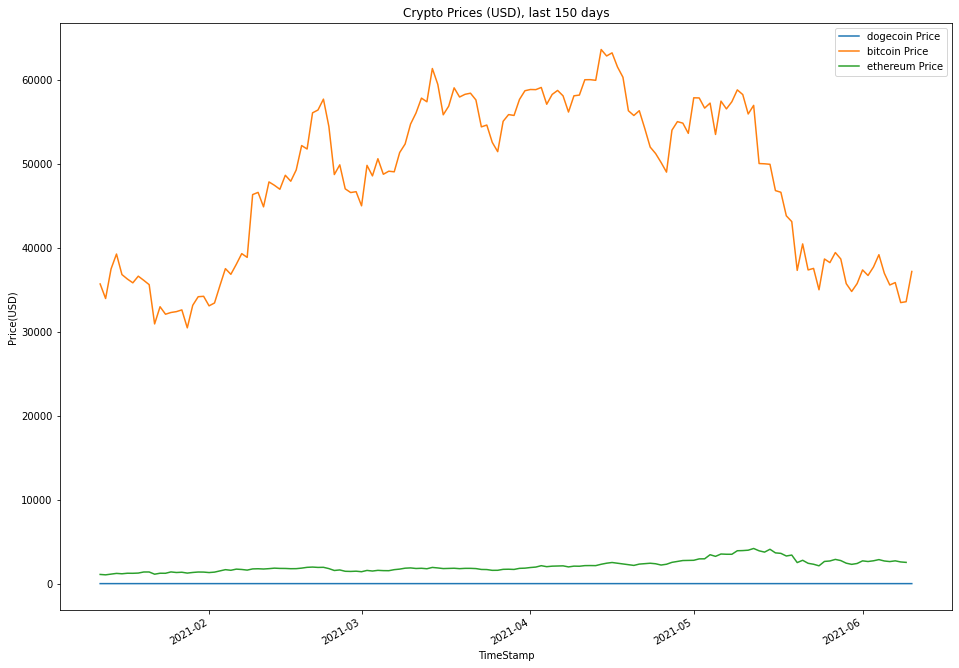

In [3]:
features_to_plot = [ 
                    'dogecoin Price', 
                    ]
    
training_data.plot(x ='TimeStamp',
               y = features_to_plot,
               figsize = (16,12),
                   subplots=True
                  )

days = url_suf[-3:]
plt.title('Dogecoin Price')
plt.xlabel('TimeStamp')
plt.ylabel('Scaled Values')

merged_df.plot(x ='TimeStamp',
               y = ['dogecoin Price',
                   'bitcoin Price',
                    'ethereum Price',
                    ],
               figsize = (16,12)
              )

plt.title('Crypto Prices (USD), last {} days'.format(days))
plt.xlabel('TimeStamp')
plt.ylabel('Price(USD)')

### 4. Observe correlations between cryptocurrencies price and all features.

<AxesSubplot:>

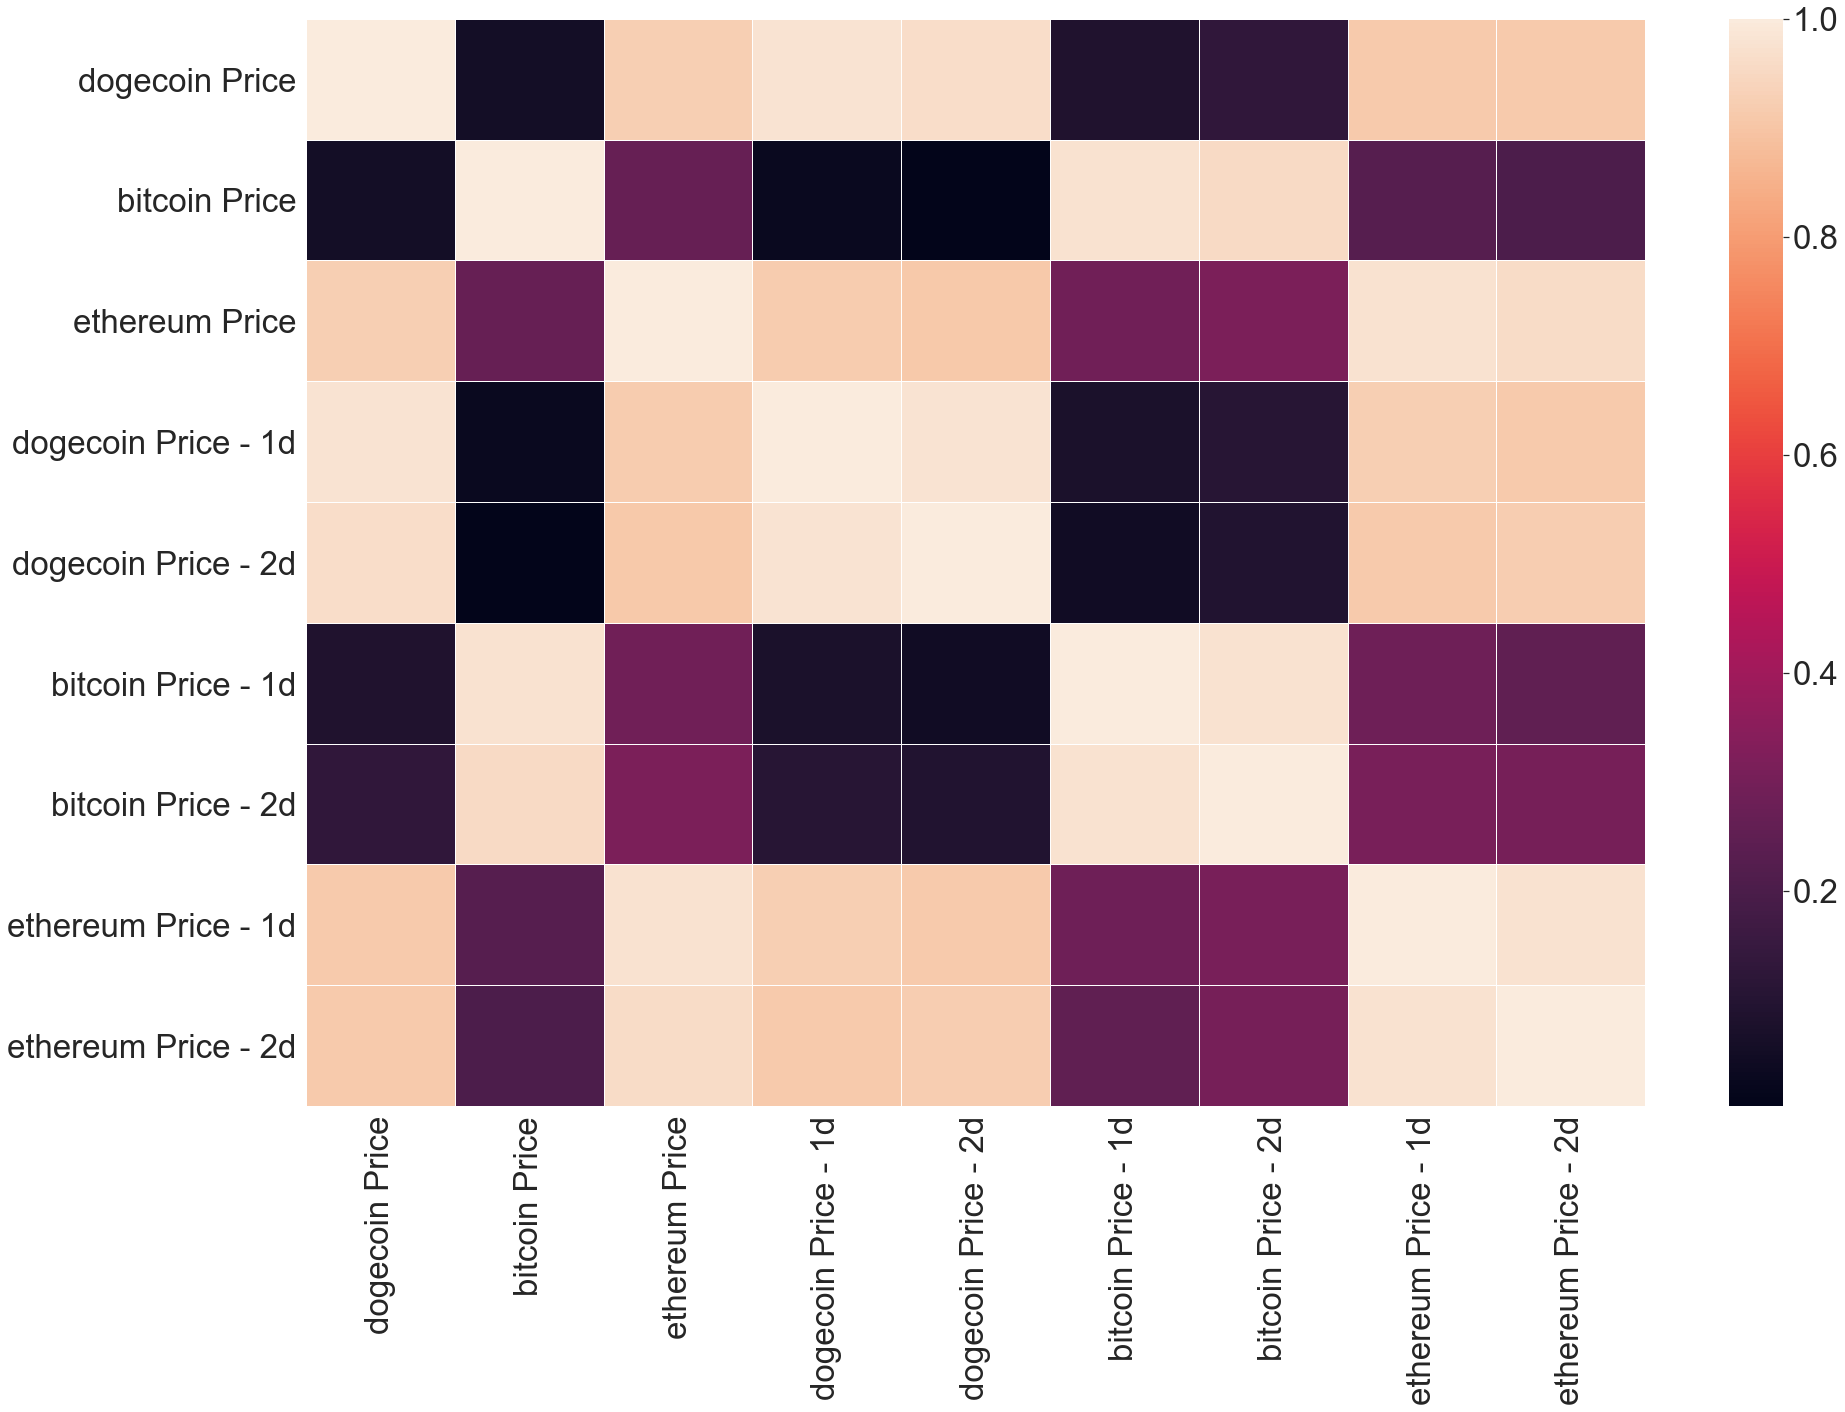

In [4]:
correlation = training_data.corr()
plt.figure(figsize=(30, 20))
sns.set(font_scale=3)
sns.heatmap(correlation, 
            xticklabels=correlation.columns.values, 
            yticklabels=correlation.columns.values, 
            annot = False,
            linewidths=.7)

### 5. Create test data set
- add 2 more rows for the future days
- populate future data with the -2day offset features from the previous 2 days.

In [5]:
dummy_rows = pd.DataFrame(np.zeros(shape=(2,len(training_data.columns))),
                          columns=training_data.columns)

dfs_to_concat = [training_data, dummy_rows]
training_and_testing = pd.concat(dfs_to_concat)

t = merged_df['TimeStamp'].values

training_and_testing.iat[-2, 0] = pd.to_datetime(t[-2]) + pd.DateOffset(days=1, minutes=1080)
training_and_testing.iat[-1, 0] = pd.to_datetime(t[-2]) + pd.DateOffset(days=2, minutes=1080)

features_to_shift = [
                    'dogecoin Price',
                     'bitcoin Price', 
                     'ethereum Price', 
                     
                    ]

features_to_fit = [
                    'dogecoin Price - 2d', 
                    'bitcoin Price - 2d',
                    'ethereum Price - 2d', 
                    
                    ]

all_model_features = [
                    'TimeStamp',
                    'dogecoin Price',
                    'dogecoin Price - 2d', 
                    'bitcoin Price - 2d',
                    'ethereum Price - 2d', 
                    
                    ]

for i in features_to_shift:
    training_and_testing.at[0, '{} - 2d'.format(i)] = training_and_testing.at[147, i]
    training_and_testing.at[1, '{} - 2d'.format(i)] = training_and_testing.at[148, i]
    
testing_data = training_and_testing.iloc[-2:][all_model_features]
testing_data

,TimeStamp,dogecoin Price,dogecoin Price - 2d,bitcoin Price - 2d,ethereum Price - 2d
0,2021-06-10 18:00:00,0.0,0.333077,0.090726,0.489302
1,2021-06-11 18:00:00,0.0,0.327442,0.093918,0.472564


### 6. linear regression model and fit it on training data.

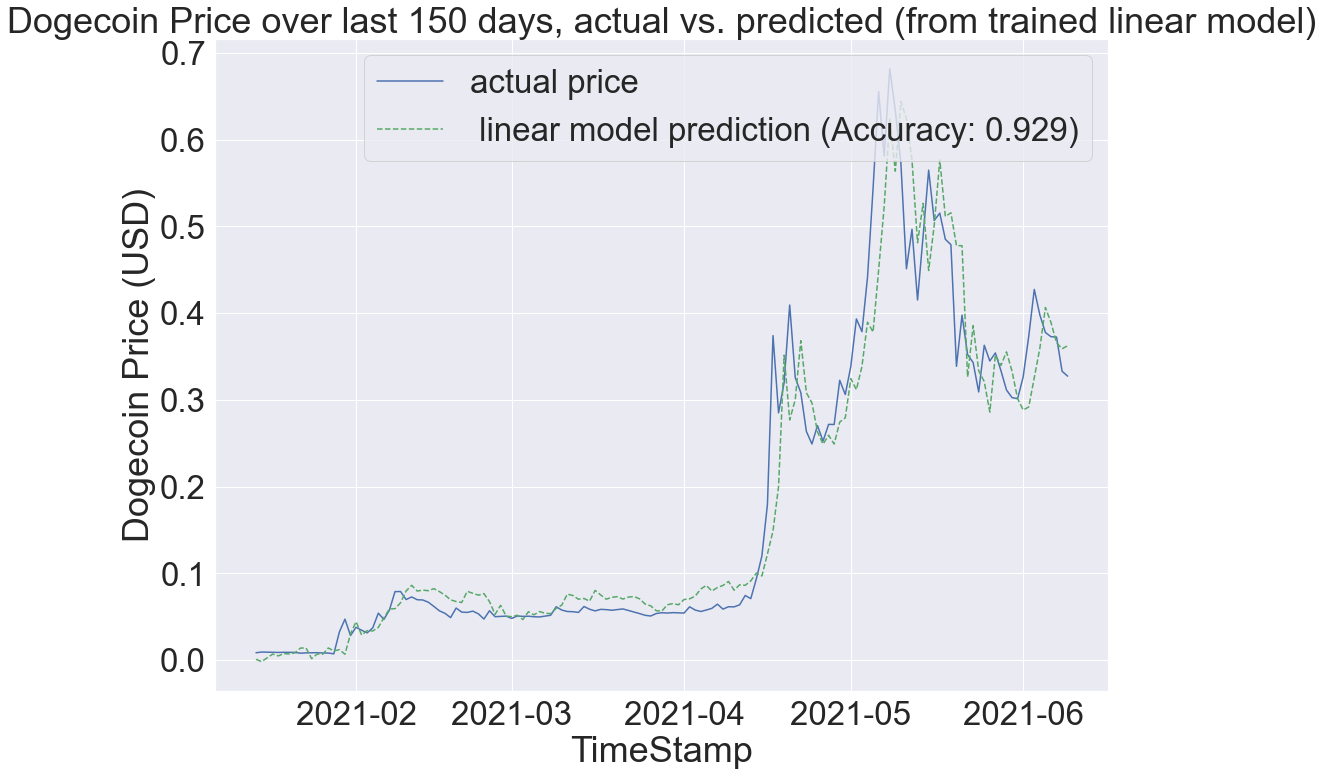

In [6]:
X_train = np.array(training_data[features_to_fit])
y_train = np.array(training_data[['dogecoin Price']])
sns.set(font_scale=3)

m_linear = LinearRegression()
m_linear.fit(X_train, y_train)
score_linear = m_linear.score(X_train, y_train)
y_pred = m_linear.predict(X_train)

X_axis = training_data['TimeStamp']
plt.figure(figsize = (16,12))
plt.plot(X_axis, y_train, label='actual price')
plt.plot(X_axis, y_pred, 'g--', label=' linear model prediction (Accuracy: {})'.format(round(score_linear, 3)))
plt.title('Dogecoin Price over last {} days, actual vs. predicted (from trained linear model)'.format(days))
plt.xlabel('TimeStamp')
plt.ylabel('Dogecoin Price (USD)')
plt.legend(loc='upper right')

### 7. Instantiate linear regression model with Ridge regularization and fit it on training data.

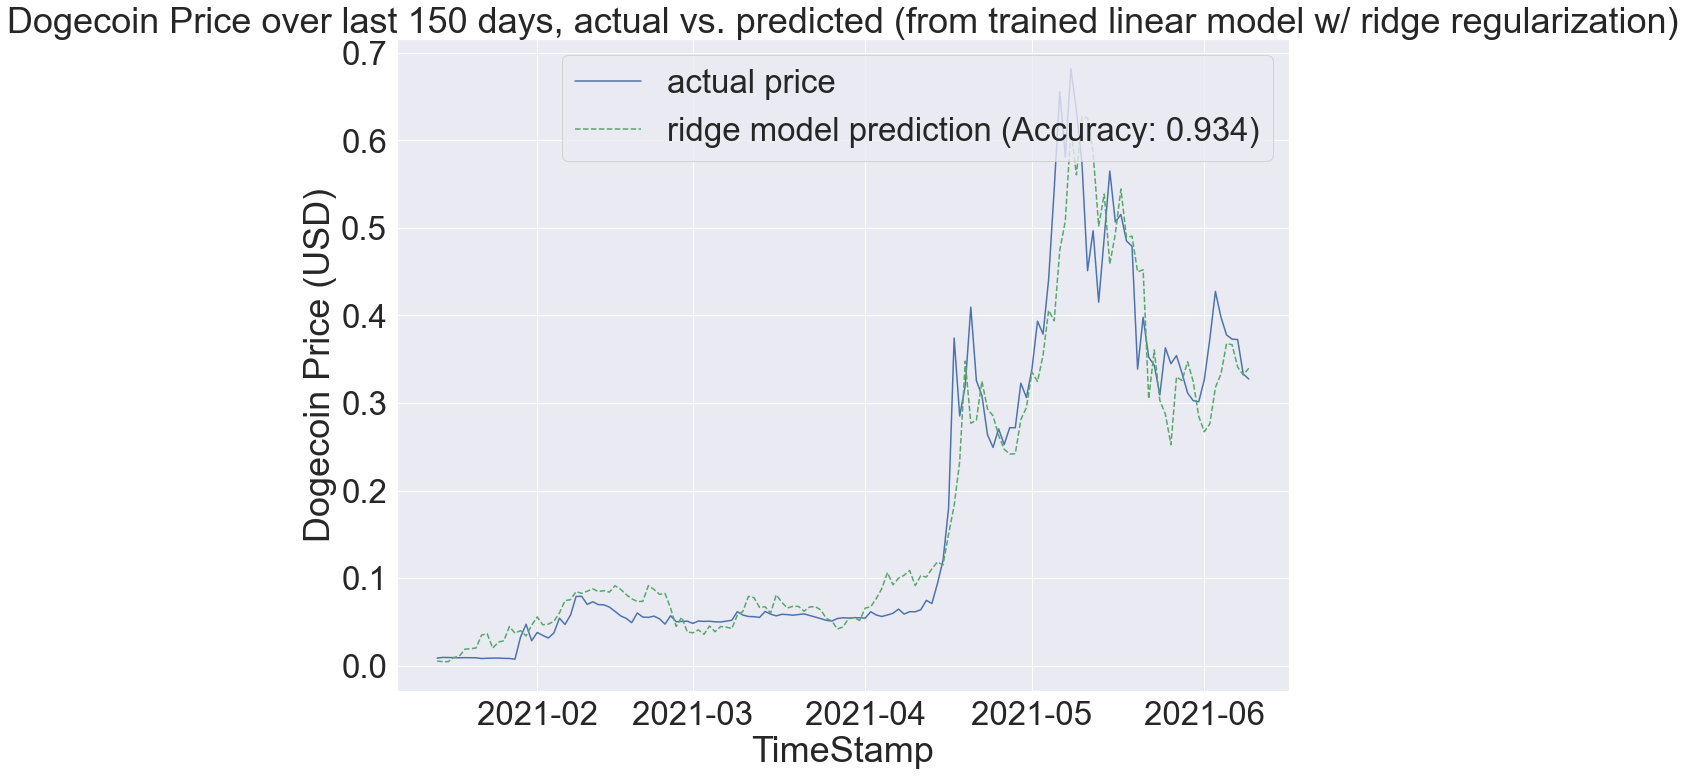

In [7]:
X_poly = PolynomialFeatures(degree=3).fit_transform(X_train)
m_ridge = Ridge(alpha = 0.5, solver='lsqr')
m_ridge.fit(X_poly, y_train)
score_ridge = m_ridge.score(X_poly, y_train)
y_pred_ridge = m_ridge.predict(X_poly)

plt.figure(figsize = (16,12))
plt.plot(X_axis, y_train, label='actual price')
plt.plot(X_axis, y_pred_ridge, 'g--', label='ridge model prediction (Accuracy: {})'.format(round(score_ridge, 3)))
plt.title('Dogecoin Price over last {} days, actual vs. predicted (from trained linear model w/ ridge regularization)'.format(days))
plt.xlabel('TimeStamp')
plt.ylabel('Dogecoin Price (USD)')
plt.legend(loc='upper right')

### 8. Apply trained linear model on the testing data set to get predicted Dogecoin prices for next 2 days.

In [8]:
testing_array = np.array(testing_data[features_to_fit])
doge_prediction = m_linear.predict(testing_array)
# doge_prediction

In [9]:
testing_data_prediction = testing_data.copy()
testing_data_prediction['dogecoin Price'] = doge_prediction
testing_data_prediction

,TimeStamp,dogecoin Price,dogecoin Price - 2d,bitcoin Price - 2d,ethereum Price - 2d
0,2021-06-10 18:00:00,0.325235,0.333077,0.090726,0.489302
1,2021-06-11 18:00:00,0.318432,0.327442,0.093918,0.472564
